In [1]:

import os
import pickle
from scipy import signal
import libfmp.b
import numpy as np
import pandas as pd
from tqdm import tqdm
from load_djembe_marker import *
from foot_module import onset_calculations, onset_extraction, onset_filtering, utils, onset_plot
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter, argrelmin, argrelmax
from pydub import AudioSegment
from scipy.signal import find_peaks
from pydub.generators import Triangle

from compute_tempo import *

In [2]:
OnsetProcessor = onset_calculations.OnsetProcessor()
FootEventDetector = onset_extraction.FootEventDetector()
onset_filtering = onset_filtering.Filtering(mocap_fps = 240)

def auto_calc_time_threshold(data):
    
    D1_diff = np.diff(data/240)
    D1_diff_filtered = D1_diff[(D1_diff >= 0) & (D1_diff <= 1)]
    threshold = np.mean(D1_diff_filtered)
    return threshold

In [ ]:
mvnx_filepath = os.listdir("/itf-fi-ml/home/sagardu/djembe_drive/Data/DD_MultiM_Proc/MoCap_proc/MVNX")
dance_annotations = os.listdir("/itf-fi-ml/home/sagardu/djembe_drive/sgr_space/subset_dance_annotation")
mnvx_files = []
cycle_file = []

for filename in dance_annotations:

    filen = filename.split("_Dancers")[0]
    mnvx_files.append(filen+"_T.mvnx")
    cycle_file.append(filen+"_C.csv")

In [3]:
nn = 2
mvnfiles = ["BKO_E1_D1_01_Suku_T.mvnx", "BKO_E1_D1_02_Maraka_T.mvnx", "BKO_E1_D1_03_Wasulunka_T.mvnx", "BKO_E1_D2_04_Maraka_T.mvnx"]
# annotation = ["BKO_E1_D1_01_Suku_Dancers.csv", "BKO_E1_D1_02_Maraka_Dancers.csv", "BKO_E1_D1_03_Wasulunka_Dancers.csv", "BKO_E1_D2_04_Maraka.csv"]
# cyclefile= ["BKO_E1_D1_01_Suku_C.csv", "BKO_E1_D1_02_Maraka_C.csv", "BKO_E1_D1_03_Wasulunka_C.csv", "BKO_E1_D2_04_Maraka_C.csv"]



file_path = f"./mocap_mvnx/{mvnfiles[nn]}"
file_name = os.path.basename(file_path).split(".")[0]
djembe_obj = djembe(file_path)

motiondata_section, _, _, _ = djembe_obj.load_djembe(frme=-1)



In [ ]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
right_hand = motiondata_section['position']['SEGMENT_RIGHT_HAND']

N = len(right_hand)
time = (np.arange(N)/240).reshape(-1,1)

mx = right_hand[:,0]
my = right_hand[:,1]
mz = right_hand[:,2]

xy = np.sqrt(mx**2 + my**2)
xz = np.sqrt(mx**2 + mz**2)
yz = np.sqrt(my**2 + mz**2)
xyz= np.sqrt(mx**2 + my**2 + mz**2).flatten()

# fig_motion = plt.figure(figsize=(12, 10))
# ax = fig_motion.add_subplot(11, projection='3d') 
# ax.plot3D(mx, mz, time, 'gray')
# ax.set_xlabel('X-axis')
# ax.set_ylabel("Y-axis")
# ax.set_zlabel("Z-axis")




In [4]:
def filter_onsets_by_distance(xyz_ab_minima, xyz_ab, distance_threshold=0.1, time_threshold=0.8, fps=240):
    # Initialize the list to store filtered onsets
    filtered_onsets = []
    
    # Iterate through the onsets
    for i in range(len(xyz_ab_minima) - 1):
        onset_current = xyz_ab_minima[i]
        onset_next = xyz_ab_minima[i + 1]
        
        # Calculate the distance between the two onsets (in terms of velocity)
        distance = np.sum(np.abs(xyz_ab[onset_current:onset_next])) / fps
        
        # Compute time difference in frames
        time_diff = (onset_next-onset_current)/fps
        
        # Apply the distance threshold
        if distance > distance_threshold and time_diff <= time_threshold:
            # Keep the next onset
            filtered_onsets.append(onset_next)
    
    return np.array(filtered_onsets)


In [5]:
# SEGMENT_HEAD  SEGMENT_PELVIS   SEGMENT_T8  SEGMENT_LEFT_HAND  SEGMENT_LEFT_FOOT

mocap_fps = 240
segment_name = 'SEGMENT_LEFT_FOOT'
vel = motiondata_section['velocity'][segment_name]

N = len(vel)
time = (np.arange(N)/240)

x_ab = np.abs(savgol_filter(vel[:,0], 60, 0))
y_ab = np.abs(savgol_filter(vel[:,1], 60, 0))
z_ab = np.abs(savgol_filter(vel[:,2], 60, 0))

# x_peaks, _ = find_peaks(x_ab)
# y_peaks, _ = find_peaks(y_ab)
# z_peaks, _ = find_peaks(z_ab)

# xyz_final = np.zeros(len(x_ab))
# window_size = 360                       # frames 
# nb_chunk = len(x_ab)//window_size
# for idx in range(0, nb_chunk*window_size, window_size):
    
#     x_pks= [pks for pks in x_peaks if (idx <= pks <= idx + window_size)]
#     y_pks= [pks for pks in y_peaks if (idx <= pks <= idx + window_size)]
#     z_pks= [pks for pks in z_peaks if (idx <= pks <= idx + window_size)]

#     # Extract values for the corresponding peaks
#     x_values = x_ab[x_pks] if x_pks else np.array([])  # Handle empty case
#     y_values = y_ab[y_pks] if y_pks else np.array([])  # Handle empty case
#     z_values = z_ab[z_pks] if z_pks else np.array([])  # Handle empty case
    
#     # Calculate local averages
#     x_local_avg = np.mean(x_values) if x_values.size > 0 else 0
#     y_local_avg = np.mean(y_values) if y_values.size > 0 else 0
#     z_local_avg = np.mean(z_values) if z_values.size > 0 else 0
    
#     # Check which average is greatest and assign to xyz_final
#     if x_local_avg > y_local_avg and x_local_avg > z_local_avg:
#         xyz_final[idx: idx + window_size] = x_ab[idx: idx + window_size]
#     elif y_local_avg > x_local_avg and y_local_avg > z_local_avg:
#         xyz_final[idx: idx + window_size] = y_ab[idx: idx + window_size]
#     elif z_local_avg > x_local_avg and z_local_avg > y_local_avg:
#         xyz_final[idx: idx + window_size] = z_ab[idx: idx + window_size]



# x_ab_minima = argrelmin(xyz_final, order=15)[0]
# XYZfiltered_onsets = filter_onsets_by_distance(x_ab_minima, xyz_final, distance_threshold=0.1, time_threshold=1.5)

# kept_onsets = XYZfiltered_onsets[xyz_final[XYZfiltered_onsets] < 0.5]
# data = np.zeros(len(x_ab))
# data[kept_onsets] = 1

# xyztempogram, xyztime_axis_seconds, xyztempo_axis_bpm = compute_tempogram_fourier(data, Fs, window_length=N, hop_size=H, tempi=Theta)
# xyztempogram_ab = np.abs(xyztempogram)

In [ ]:
def novelty_velocity(data, order=15, distance_threshold=0.01, time_threshold=1.5, onset_threshold=0.5):
    minima_indices = argrelmin(data, order=order)[0]
    filtered_onsets = filter_onsets_by_distance(minima_indices, data, distance_threshold=distance_threshold, time_threshold=time_threshold)
    kept_onsets = filtered_onsets[data[filtered_onsets] < onset_threshold]   # filter out onsets based on velocity threshold
    binary_onset_data = np.zeros(len(data))
    binary_onset_data[kept_onsets] = 1
    return binary_onset_data

In [6]:
x_ab = np.abs(savgol_filter(vel[:,0], 60, 0))
y_ab = np.abs(savgol_filter(vel[:,1], 60, 0))
z_ab = np.abs(savgol_filter(vel[:,2], 60, 0))

x_ab_minima = argrelmin(x_ab, order=15)[0]
Xfiltered_onsets = filter_onsets_by_distance(x_ab_minima, x_ab, distance_threshold=0.01, time_threshold=1.5)
xkept_onsets = Xfiltered_onsets[x_ab[Xfiltered_onsets] < 0.5]
datax = np.zeros(len(x_ab))
datax[xkept_onsets] = 1

y_ab_minima = argrelmin(y_ab, order=15)[0]
Yfiltered_onsets = filter_onsets_by_distance(y_ab_minima, y_ab, distance_threshold=0.01, time_threshold=1.5)
ykept_onsets = Yfiltered_onsets[y_ab[Yfiltered_onsets] < 0.5]
datay = np.zeros(len(y_ab))
datay[ykept_onsets] = 1

z_ab_minima = argrelmin(z_ab, order=15)[0]
Zfiltered_onsets = filter_onsets_by_distance(z_ab_minima, z_ab, distance_threshold=0.01, time_threshold=1.5)
zkept_onsets = Zfiltered_onsets[z_ab[Zfiltered_onsets] < 0.5]
dataz = np.zeros(len(z_ab))
dataz[zkept_onsets] = 1


Fs = 240
N = 240*5 #corresponding to 3 seconds (Fs = 100)
H = 10
Theta = np.arange(50,240,10)

xtempogram, xtime_axis_seconds, xtempo_axis_bpm = compute_tempogram_fourier(datax, Fs, window_length=N, hop_size=H, tempi=Theta)
xtempogram_ab = np.abs(xtempogram)

ytempogram, ytime_axis_seconds, ytempo_axis_bpm = compute_tempogram_fourier(datay, Fs, window_length=N, hop_size=H, tempi=Theta)
ytempogram_ab = np.abs(ytempogram)

ztempogram, ztime_axis_seconds, ztempo_axis_bpm = compute_tempogram_fourier(dataz, Fs, window_length=N, hop_size=H, tempi=Theta)
ztempogram_ab = np.abs(ztempogram)

In [ ]:
# plt.figure(figsize=(100, 12), dpi=200)
# plt.plot(time, x_ab, linewidth=0.3)

# plt.figure(figsize=(100, 12), dpi=200)
# plt.plot(time, y_ab, linewidth=0.3)

# plt.figure(figsize=(100, 12), dpi=200)
# plt.plot(time, z_ab, linewidth=0.3)

plt.figure(figsize=(100, 12), dpi=200)
plt.plot(time, dataz, linewidth=0.3)
plt.plot(time, z_ab, linewidth=0.5)
plt.title(f'{segment_name}')
plt.show()

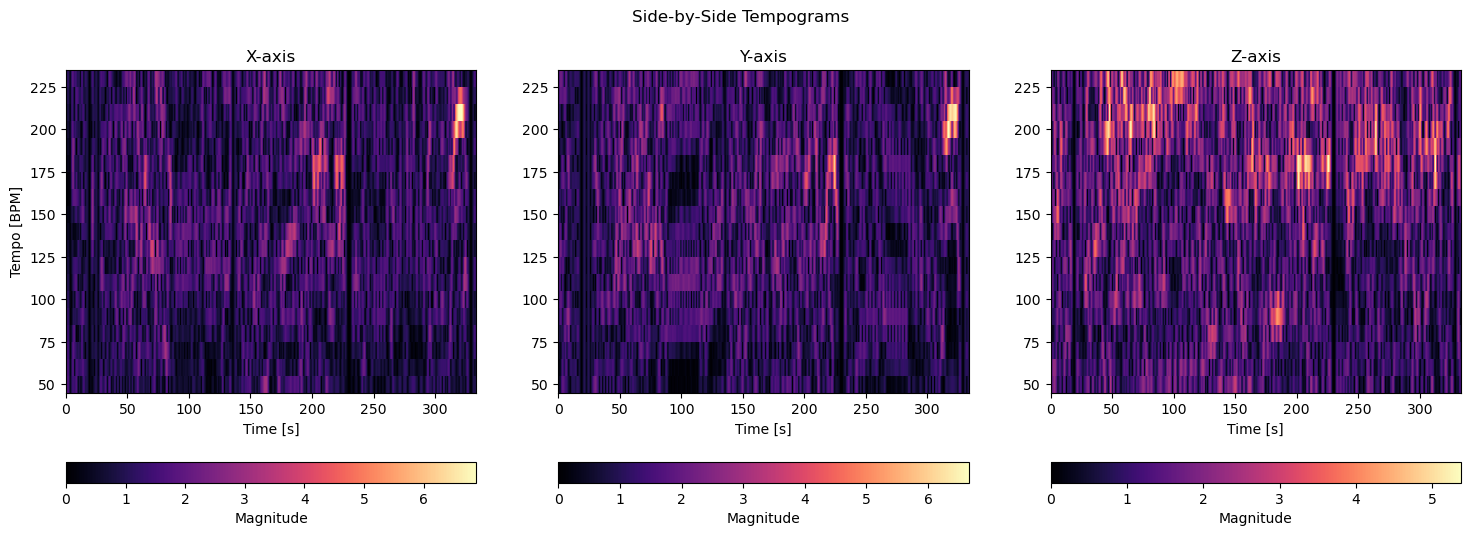

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=False)

# Tempogram 1
cax1 = axs[0].pcolormesh(xtime_axis_seconds, xtempo_axis_bpm, xtempogram_ab, shading='auto', cmap='magma')
axs[0].set_title('X-axis')
axs[0].set_xlabel('Time [s]')
axs[0].set_ylabel('Tempo [BPM]')
plt.colorbar(cax1, ax=axs[0], orientation='horizontal', label='Magnitude')

# Tempogram 2
cax2 = axs[1].pcolormesh(ytime_axis_seconds, ytempo_axis_bpm, ytempogram_ab, shading='auto', cmap='magma')
axs[1].set_title('Y-axis')
axs[1].set_xlabel('Time [s]')
plt.colorbar(cax2, ax=axs[1], orientation='horizontal', label='Magnitude')

# Tempogram 3
cax3 = axs[2].pcolormesh(ztime_axis_seconds, ztempo_axis_bpm, ztempogram_ab, shading='auto', cmap='magma')
axs[2].set_title('Z-axis')
axs[2].set_xlabel('Time [s]')
plt.colorbar(cax3, ax=axs[2], orientation='horizontal', label='Magnitude')

# plt.colorbar(axs[1].collections[0], ax=axs, orientation='horizontal', label='Magnitude')

plt.suptitle('Side-by-Side Tempograms')
# plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(100, 12), dpi=100)

plt.plot(time, x_ab, label='X', linewidth=0.4)
plt.scatter(xkept_onsets/240, x_ab[xkept_onsets], color='red', label='Directional Changes', zorder=5, s=4)
# plt.hlines(y=np.array([0.982, 0.676 +3, 0.646 +6]), xmin=0.0, xmax=N/240, color='r', linestyle='dotted', linewidth=0.3)
# plt.vlines(x=np.array([100, 101.5, 102, 105, 110]), ymin=0.0, ymax=9, color='r', linestyle='dotted', linewidth=0.5)

plt.title('Changes in Signal')
plt.legend(loc='upper left')
plt.show()

In [ ]:
num_frames = xtempogram_ab.shape[1]
tempo_curve = np.zeros(num_frames)

for frame_idx in range(num_frames):
    # Find the index of the maximum value in the tempogram at the current frame
    prominent_tempo_idx = np.argmax(np.abs(xtempogram_ab[:, frame_idx]))
    tempo_curve[frame_idx] = xtempo_axis_bpm[prominent_tempo_idx]
    
plt.figure(figsize=(40, 6))
plt.plot(xtime_axis_seconds, tempo_curve)
plt.xlabel('Time (seconds)')
plt.ylabel('Tempo (BPM)')
plt.title('Tempo Curve Over Time')
plt.grid(True)
plt.show()

In [8]:
tempogram = xtempogram
sampling_rate= 240 
curve_length = len(datax)
window_length = N
hop_size = H
tempi = Theta


hann_window = np.hanning(window_length)
half_window_length = window_length // 2
left_padding = half_window_length
right_padding = half_window_length
padded_curve_length = curve_length + left_padding + right_padding
nov_PLP = np.zeros(padded_curve_length)
num_frames = tempogram.shape[1]
# magnitude_tempogram = np.abs(tempogram)

# tempo_curve = np.zeros(padded_curve_length)

abs_tempogram_list = [xtempogram_ab, ytempogram_ab, ztempogram_ab]
tempogram_list = [xtempogram, ytempogram, ztempogram]

for frame_idx in range(num_frames):
    sinusoidal_kernel_add = np.zeros(window_length)
    sinusoidal_kernel_arr = np.empty((0, window_length))
    freq_arr = np.array([])
    phase_arr = np.array([])
    for i in range(3):
    
        # select peak frequency for a time window
        peak_tempo_idx = np.argmax(abs_tempogram_list[i][:, frame_idx])
        peak_tempo_bpm = tempi[peak_tempo_idx]
        frequency = (peak_tempo_bpm / 60) / sampling_rate
        freq_arr = np.concatenate(( freq_arr, np.array([frequency]) ))
        
        # get the complex value for that peak frequency and time window
        complex_value = tempogram_list[i][peak_tempo_idx, frame_idx]
        phase = - np.angle(complex_value) / (2 * np.pi)
        phase_arr = np.concatenate(( phase_arr, np.array([phase]) ))
        
        
        start_index = frame_idx * hop_size
        end_index = start_index + window_length
        time_kernel = np.arange(start_index, end_index)
        
        # sinusoidal_kernel = hann_window * np.cos(2 * np.pi * (time_kernel * frequency - phase))
        # sinusoidal_kernel_arr = np.vstack([sinusoidal_kernel_arr, sinusoidal_kernel])
        # sinusoidal_kernel_add += sinusoidal_kernel
    
    f_idx = np.argmax(freq_arr)
    selected_freq = freq_arr[f_idx]
    selected_phase = phase_arr[f_idx]
    sinusoidal_kernel = hann_window * np.cos(2 * np.pi * (time_kernel * selected_freq - selected_phase))
    nov_PLP[time_kernel] += sinusoidal_kernel

        # plt.figure(figsize=(5, 5), dpi=100)
        # plt.plot(sinusoidal_kernel, linewidth=0.3)
        # plt.show()
        
    # print(freq_arr)
    # print(phase_arr)
    
    # plt.figure(figsize=(5, 5), dpi=100)
    # plt.plot(sinusoidal_kernel, linewidth=0.3)
    # plt.show()
    
    # if frame_idx == 0:
    #     break
    # tempo_curve[time_kernel] = peak_tempo_bpm
    
nov_PLP = nov_PLP[left_padding:padded_curve_length-right_padding]
nov_PLP[nov_PLP < 0] = 0

In [58]:
print(freq_arr)
print(phase_arr)

f_idx = np.argmax(freq_arr)
selected_freq = freq_arr[f_idx]
selected_phase = phase_arr[f_idx]

[0.00347222 0.00833333 0.00763889]
[ 0.47603708 -0.45238872  0.08887881]


1

In [9]:
nov=datax
Fs_nov = 240
L = len(nov)

# nov_PLP, tempo_curve = compute_predominant_local_pulse(xtempogram_ab, Fs_nov, L, N, H, Theta)
t_nov = np.arange(nov.shape[0]) / Fs_nov

peaks, properties = signal.find_peaks(nov_PLP)  # , prominence=0.02
peaks_sec = t_nov[peaks]

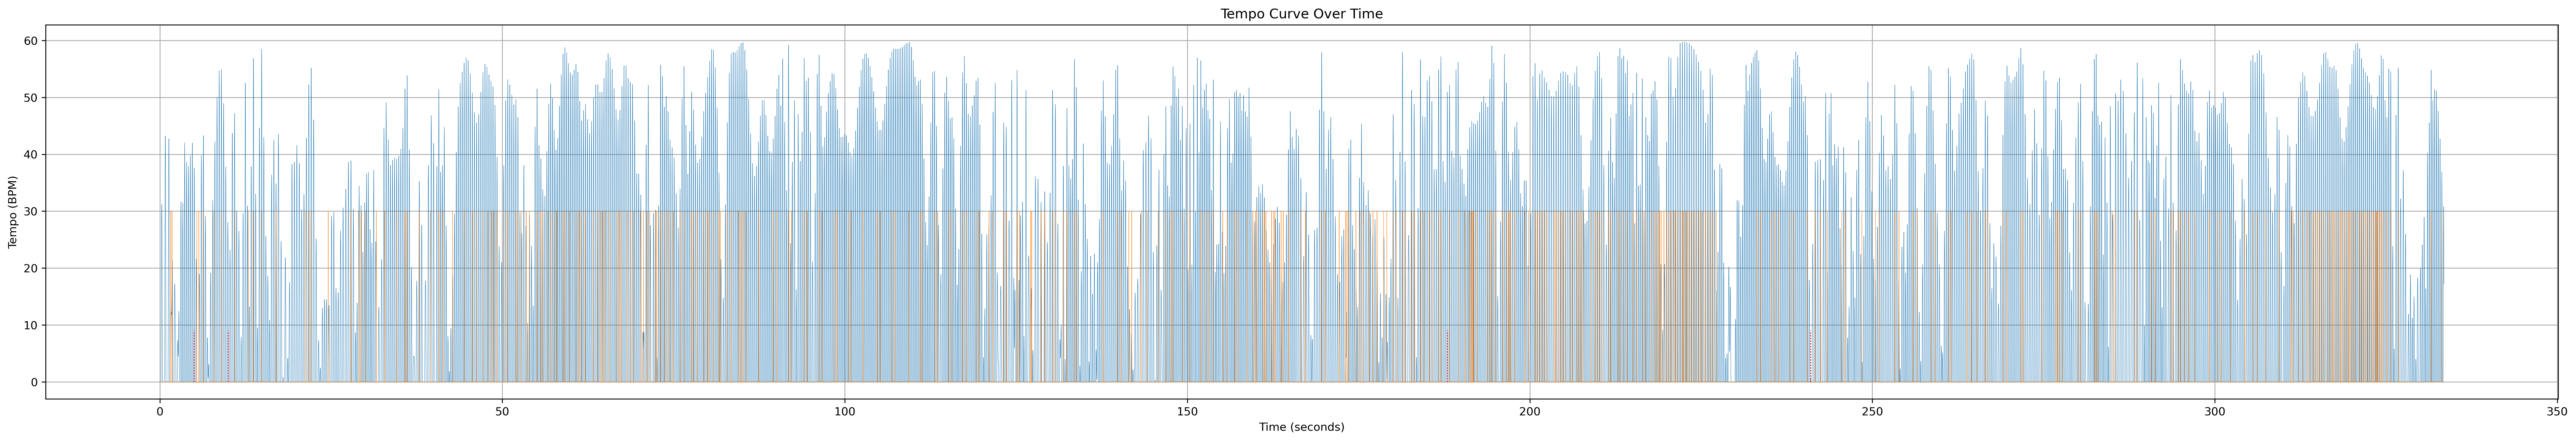

In [10]:
plt.figure(figsize=(40, 6), dpi=300)
plt.plot(time,nov_PLP, linewidth=0.3)
plt.plot(time,30*datax, linewidth=0.3)
# plt.plot(tempo_curve, linewidth=0.3)
plt.vlines(x=np.array([5, 10, 188, 241]), ymin=0.0, ymax=9, color='r', linestyle='dotted', linewidth=0.9)
plt.xlabel('Time (seconds)')
plt.ylabel('Tempo (BPM)')
plt.title('Tempo Curve Over Time')
plt.grid(True)
plt.show()

In [11]:
click_duration = 50  # milliseconds
click_freq = 1200  # Hz

# Generate a single click sound
click = Triangle(click_freq).to_audio_segment(duration=click_duration)

onset_times = peaks_sec  # kept_onsets/240
dN = len(vel)
total_duration = (dN/240)*1000  #  in milliseconds

audio = AudioSegment.silent(duration=total_duration)
for onset in onset_times:
    position = int(onset * 1000)  # Convert onset time to milliseconds
    audio = audio.overlay(click, position=position)

# Export the audio with clicks to a file
audio.export(os.path.join("/itf-fi-ml/home/sagardu/extract_feet_onset", f"{file_name}_FOOTVELO_TEMPO_10sec_upto240bpm_prop1.wav"), format="wav")

<_io.BufferedRandom name='/itf-fi-ml/home/sagardu/extract_feet_onset/BKO_E1_D1_03_Wasulunka_T_FOOTVELO_TEMPO_10sec_upto240bpm_prop1.wav'>

### Dance Structure Analysis

In [127]:
def compute_sm_dot(X, Y):
    """Computes similarty matrix from feature sequences using dot (inner) product

    Notebook: C4/C4S2_SSM.ipynb

    Args:
        X (np.ndarray): First sequence
        Y (np.ndarray): Second Sequence

    Returns:
        S (float): Dot product
    """
    S = np.dot(np.transpose(X), Y)
    return S

def plot_feature_ssm(X, Fs_X, S, Fs_S, ann, duration, color_ann=None,
                     title='', label='Time (seconds)', time=True,
                     figsize=(15, 15), fontsize=10, clim_X=None, clim=None):
    """Plot SSM along with feature representation and annotations (standard setting is time in seconds)

    Notebook: C4/C4S2_SSM.ipynb

    Args:
        X: Feature representation
        Fs_X: Feature rate of ``X``
        S: Similarity matrix (SM)
        Fs_S: Feature rate of ``S``
        ann: Annotaions
        duration: Duration
        color_ann: Color annotations (see :func:`libfmp.b.b_plot.plot_segments`) (Default value = None)
        title: Figure title (Default value = '')
        label: Label for time axes (Default value = 'Time (seconds)')
        time: Display time axis ticks or not (Default value = True)
        figsize: Figure size (Default value = (5, 6))
        fontsize: Font size (Default value = 10)
        clim_X: Color limits for matrix X (Default value = None)
        clim: Color limits for matrix ``S`` (Default value = None)

    Returns:
        fig: Handle for figure
        ax: Handle for axes
    """
    cmap = libfmp.b.compressed_gray_cmap(alpha=-100)
    fig, ax = plt.subplots(3, 3, gridspec_kw={'width_ratios': [0.1, 1, 0.05],
                                              'wspace': 0.2,
                                              'height_ratios': [0.3, 1, 0.1]},
                           figsize=figsize)
    libfmp.b.plot_matrix(X, Fs=Fs_X, ax=[ax[0, 1], ax[0, 2]], clim=clim_X,
                         xlabel='', ylabel='', title=title)
    ax[0, 0].axis('off')
    libfmp.b.plot_matrix(S, Fs=Fs_S, ax=[ax[1, 1], ax[1, 2]], cmap=cmap, clim=clim,
                         title='', xlabel='', ylabel='', colorbar=True)
    ax[1, 1].set_xticks([])
    ax[1, 1].set_yticks([])
    # libfmp.b.plot_segments(ann, ax=ax[2, 1], time_axis=time, fontsize=fontsize,
    #                        colors=color_ann,
    #                        time_label=label, time_max=duration*Fs_X)
    # ax[2, 2].axis('off')
    # ax[2, 0].axis('off')
    # libfmp.b.plot_segments(ann, ax=ax[1, 0], time_axis=time, fontsize=fontsize,
    #                        direction='vertical', colors=color_ann,
    #                        time_label=label, time_max=duration*Fs_X)
    return fig, ax

In [125]:
# Tempogram feature sequence
# nov, Fs_nov = libfmp.c6.compute_novelty_spectrum(x, Fs=Fs, N=2048, H=512, gamma=100, M=10, norm=True)
# nov, Fs_nov = libfmp.c6.resample_signal(nov, Fs_in=Fs_nov, Fs_out=100)

x_duration = len(data)/240

N, H = 2400, 100
# X, T_coef, F_coef_BPM = libfmp.c6.compute_tempogram_fourier(nov, Fs_nov, N=N, H=H, Theta=np.arange(30, 601))
octave_bin = 12
tempogram_F = np.abs(X)
output = libfmp.c6.compute_cyclic_tempogram(tempogram_F, F_coef_BPM, octave_bin=octave_bin)
X = output[0]
F_coef_scale = output[1]
Fs_X = Fs_nov/H
X = libfmp.c3.normalize_feature_sequence(X, norm='2', threshold=0.001)
S = compute_sm_dot(X,X)
ann_frames = None   #libfmp.c4.convert_structure_annotation(ann, Fs=Fs_X) 


In [ ]:
fig, ax = plot_feature_ssm(X, 1, S, 1, ann_frames, x_duration*Fs_X, color_ann=None,
    title='Tempogram (Fs=%0.2f)'%Fs_X, label='Time (frames)')
# X = libfmp.c3.normalize_feature_sequence(X, norm='2', threshold=0.001)
# plt.figure(figsize=(10, 10), dpi=300)
# S = compute_sm_dot(X,X)
# plt.matshow(S)

In [ ]:
# from sklearn.preprocessing import MinMaxScaler, normalize
# scaler= MinMaxScaler()


# xy_resultant = np.linalg.norm(vel[:, :2], axis=1)  # Norm of x and y components
# yz_resultant = np.linalg.norm(vel[:, 1:], axis=1)  # Norm of y and z components
# xz_resultant = np.linalg.norm(vel[:, [0, 2]], axis=1)  # Norm of x and z components

# xyz_resultant_pos = np.linalg.norm(pos, axis=1)  # Norm of x, y, and z components
# xyz_resultant_vel = np.linalg.norm(vel, axis=1)  # Norm of x, y, and z components
# xyz_resultant_acc = np.linalg.norm(acc, axis=1)  # Norm of x, y, and z components

# resultant_vel =  savgol_filter(xyz_resultant_vel, 60, 0) #right_hand[:,1]
# resultant_acc =  savgol_filter(xyz_resultant_acc, 60, 0) #right_hand[:,1]

# x_normalized = normalize([vel[:,0]]).flatten()
# y_normalized = normalize([vel[:,1]]).flatten()
# z_normalized = normalize([vel[:,2]]).flatten()


# xyz_ab = np.sqrt(x_ab**2 + y_ab**2 + z_ab**2 )

# x_ab_minima = argrelmin(x_ab, order=15)[0]
# y_ab_minima = argrelmin(y_ab, order=15)[0]
# z_ab_minima = argrelmin(z_ab, order=15)[0]


# Xfiltered_onsets = filter_onsets_by_distance(x_ab_minima, x_ab, distance_threshold=0.1)
# Yfiltered_onsets = filter_onsets_by_distance(y_ab_minima, y_ab, distance_threshold=0.1)
# Zfiltered_onsets = filter_onsets_by_distance(z_ab_minima, z_ab, distance_threshold=0.1)


In [ ]:


# Sample velocity data along the x-axis (vel[:,0])
vel_x = vel[:,0]

# Define your sampling rate (in Hz)
sampling_rate = 240  # example: 240 Hz, adjust according to your data

# Compute the FFT
fft_result = np.fft.fft(vel_x)
fft_freqs = np.fft.fftfreq(len(vel_x), d=1/sampling_rate)

# Take the magnitude of the FFT result
fft_magnitude = np.abs(fft_result)

# Plot the FFT magnitude (only the positive frequencies)
plt.figure(figsize=(10, 6))
plt.plot(fft_freqs[:len(fft_freqs)//2], fft_magnitude[:len(fft_magnitude)//2])
plt.title('FFT of Velocity Data (X-axis)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.xlim(0,5)
plt.grid(True)
plt.show()


In [ ]:
def compute_stft(signal_data, fs=1.0, window='hann', nperseg=256, noverlap=None, nfft=None, return_onesided=True, boundary='zeros', padded=True, axis=-1):
    """
    Compute the Short-Time Fourier Transform (STFT) of a signal.

    Parameters:
    - signal_data (array-like): Input signal.
    - fs (float, optional): Sampling frequency of the signal. Default is 1.0.
    - window (str or tuple or array-like, optional): Desired window to use. Default is 'hann'.
    - nperseg (int, optional): Length of each segment. Default is 256.
    - noverlap (int, optional): Number of points to overlap between segments. Default is None (nperseg//2).
    - nfft (int, optional): Number of points in FFT. If None, nfft = nperseg. Default is None.
    - return_onesided (bool, optional): If True, return a one-sided spectrum for real data. Default is True.
    - boundary (str, optional): Specifies how to handle boundaries. Default is 'zeros'.
    - padded (bool, optional): Specifies whether the input signal is zero-padded. Default is True.
    - axis (int, optional): Axis over which to compute the STFT. Default is the last axis (-1).

    Returns:
    - f (ndarray): Array of sample frequencies.
    - t (ndarray): Array of segment times.
    - Zxx (ndarray): STFT of `signal_data`.
    """
    f, t, Zxx = signal.stft(signal_data, fs=fs, window=window, nperseg=nperseg, noverlap=noverlap, 
                            nfft=nfft, return_onesided=return_onesided, boundary=boundary, 
                            padded=padded, axis=axis)
    
    return f, t, Zxx

# Example usage:
# Assuming 'data' is your signal and 'fs' is the sampling frequency
# data = np.random.randn(1024)  # Example signal
fs = 240  # Sampling frequency (in Hz)
window = 'hann'  # Window type
nperseg = 480  # Window size
noverlap = 240  # Overlap between windows

# Compute the STFT

data = savgol_filter(vel[:,0], 60, 0)
f, t, Zxx = compute_stft(data, fs=fs, window=window, nperseg=nperseg, noverlap=noverlap)

# Convert to log amplitude (in dB)
Zxx_log = 20 * np.log10(np.abs(Zxx))


plt.figure(figsize=(15, 15), dpi=300)
# Plot the STFT magnitude
plt.pcolormesh(t, f, Zxx_log, shading='auto', vmin=Zxx_log.min(), vmax=Zxx_log.max())
# plt.yscale('log')  # Set y-axis (frequency) to log scale
plt.ylim(0, 5)
plt.title('STFT (Log Amplitude and Log Frequency)')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
# plt.savefig('stft_magnitude.png', dpi=300)
# plt.figure(dpi=300)
plt.show()


In [ ]:
# def filter_directional_changes(directional_changes, xyz, pos_threshold=0.5, time_window=0.5, fps=240):
#     """
#     Filter directional changes based on position difference and time window constraints.

#     Parameters:
#     - directional_changes: List of onset frame numbers where directional changes occur.
#     - xyz: Array of shape (n, 3) containing x, y, z positions of the hand.
#     - pos_threshold: Minimum position difference to keep consecutive onsets (default 0.3 meters).
#     - time_window: Maximum time difference between consecutive onsets to keep them (default 1 second).
#     - fps: Frame rate of the data, used to convert time_window into frames (default 240 frames per second).

#     Returns:
#     - List of filtered directional changes (onset frame numbers).
#     """
#     filtered_onsets = []
#     time_threshold = time_window * fps  # Convert time window to frames

#     i = 0
#     while i < len(directional_changes) - 1:
#         onset_i = directional_changes[i]
#         onset_next = directional_changes[i + 1]
        
#         # Compute position difference between two consecutive onsets
#         pos_diff = np.linalg.norm(xyz[onset_next] - xyz[onset_i])
        
#         # Compute time difference in frames
#         time_diff = onset_next - onset_i
        
#         # Apply position and time window thresholds
#         if pos_diff >= pos_threshold and time_diff <= time_threshold:
#             # Keep both onsets if they meet the criteria
#             filtered_onsets.extend([onset_i, onset_next])
#             i += 2  # Move to the next pair (i+2)
#         else:
#             # Discard both onsets and move to the next pair
#             i += 2
    
#     return np.array(filtered_onsets)


# filtered_directional_changes = filter_directional_changes(directional_changes, xyz_resultant,pos_threshold=0.000, time_window=2.5, fps=240)

plt.figure(figsize=(50, 10), dpi=100)
plt.plot(resultant, label='Original Signal')
plt.scatter(directional_changes, resultant[directional_changes], color='red', label='Directional Changes', zorder=5)
plt.title('Directional Changes in Signal')
plt.legend()
plt.show()